In [78]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [79]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [80]:
y.shape, tx.shape

((10000,), (10000, 2))

# Computing the Cost Function
Fill in the `compute_cost` function below:

In [81]:
def calculate_mse(e):
    """Calculate the mse for vector e."""
    return 1/2*np.mean(e**2)


def calculate_mae(e):
    """Calculate the mae for vector e."""
    return np.mean(np.abs(e))


def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y - tx.dot(w)
    return calculate_mse(e)

# Grid Search

Fill in the function `grid_search()` below:

In [82]:
# from costs import *

def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    loss = np.zeros((len(w0), len(w1)))
    # compute loss for each combinationof w0 and w1.
    for ind_row, row in enumerate(w0):
        for ind_col, col in enumerate(w1):
            w = np.array([row, col])
            loss[ind_row, ind_col] = compute_loss(y, tx, w)
    return loss

Let us play with the grid search demo now!

Grid Search: loss*=42.42448314678248, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.014 seconds


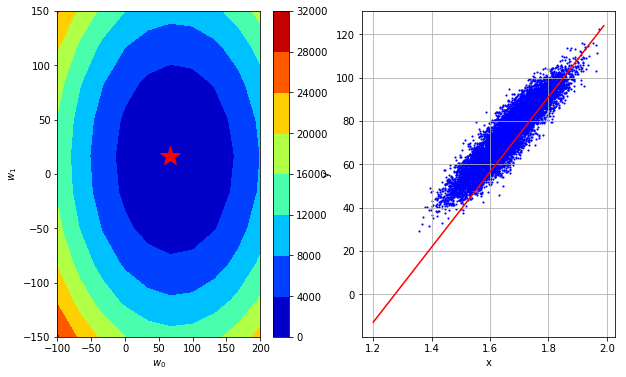

In [83]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [84]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

Please fill in the functions `gradient_descent` below:

In [85]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute loss, gradient
        grad, err = compute_gradient(y, tx, w)
        loss = calculate_mse(err)
        # update w by gradient descent
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [86]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2792.2367127591674, w0=51.30574540147369, w1=9.435798704492312
Gradient Descent(1/49): loss=265.30246210895854, w0=66.69746902191572, w1=12.266538315840002
Gradient Descent(2/49): loss=37.87837955044118, w0=71.31498610804834, w1=13.115760199244331
Gradient Descent(3/49): loss=17.41021212017447, w0=72.70024123388814, w1=13.37052676426563
Gradient Descent(4/49): loss=15.568077051450457, w0=73.11581777164007, w1=13.446956733772023
Gradient Descent(5/49): loss=15.402284895265295, w0=73.24049073296565, w1=13.469885724623941
Gradient Descent(6/49): loss=15.38736360120863, w0=73.27789262136334, w1=13.476764421879516
Gradient Descent(7/49): loss=15.38602068474353, w0=73.28911318788263, w1=13.478828031056189
Gradient Descent(8/49): loss=15.385899822261674, w0=73.29247935783843, w1=13.47944711380919
Gradient Descent(9/49): loss=15.385888944638305, w0=73.29348920882516, w1=13.47963283863509
Gradient Descent(10/49): loss=15.3858879656522, w0=73.29379216412119, w1=13.47

In [87]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure>

# Stochastic gradient descent

In [88]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            grad, _ = compute_stoch_gradient(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # calculate loss
            loss = compute_loss(y, tx, w)
            # store w and loss
            ws.append(w)
            losses.append(loss)

        print("SGD({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [89]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0/49): loss=2368.5568763553542, w0=6.171073326055082, w1=-0.6929782970183794
SGD(1/49): loss=2030.4128077722064, w0=11.824358068629802, w1=-2.3805066566609376
SGD(2/49): loss=1882.4592088860725, w0=15.486840018797306, w1=-6.331595311083898
SGD(3/49): loss=1422.4554223962184, w0=23.099084903383545, w1=-3.6847100046847476
SGD(4/49): loss=1256.940132138785, w0=26.834600251886528, w1=-4.538054103890629
SGD(5/49): loss=900.3074086777259, w0=33.373894227266824, w1=0.20438102391205248
SGD(6/49): loss=603.9485982262493, w0=39.26561406154602, w1=9.097968556426796
SGD(7/49): loss=480.3306019062167, w0=42.81404844972528, w1=12.548725697325075
SGD(8/49): loss=399.4285921619436, w0=45.58662205929873, w1=14.104963157168335
SGD(9/49): loss=322.819590011557, w0=48.707390631092835, w1=16.69994215159009
SGD(10/49): loss=293.6570417415089, w0=50.20832698895222, w1=18.337449627761586
SGD(11/49): loss=250.41985215224364, w0=52.556059168074086, w1=19.804977144369964
SGD(12/49): loss=210.63124749063272, 

In [90]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

A Jupyter Widget

<function __main__.plot_figure>

# Subgradient descent

In [91]:
def compute_subgradient(y, tx, w):
    """Compute the subgradient."""
    err = y - tx.dot(w)
    grad = -np.dot(tx.T,np.sign(err)) / len(err)
    return grad, err

In [92]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """SubGradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute loss, gradient
        grad, err = compute_subgradient(y, tx, w)
        loss = calculate_mae(err)
        # gradient w by descent update
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Sub Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [93]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = subgradient_descent(
    y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

Sub Gradient Descent(0/499): loss=73.29392200210518, w0=0.7, w1=-2.546585164964199e-16
Sub Gradient Descent(1/499): loss=72.59392200210517, w0=1.4, w1=-5.093170329928398e-16
Sub Gradient Descent(2/499): loss=71.89392200210517, w0=2.0999999999999996, w1=-7.639755494892597e-16
Sub Gradient Descent(3/499): loss=71.19392200210518, w0=2.8, w1=-1.0186340659856795e-15
Sub Gradient Descent(4/499): loss=70.49392200210517, w0=3.5, w1=-1.2732925824820993e-15
Sub Gradient Descent(5/499): loss=69.79392200210518, w0=4.2, w1=-1.5279510989785191e-15
Sub Gradient Descent(6/499): loss=69.09392200210517, w0=4.9, w1=-1.782609615474939e-15
Sub Gradient Descent(7/499): loss=68.39392200210517, w0=5.6000000000000005, w1=-2.0372681319713587e-15
Sub Gradient Descent(8/499): loss=67.69392200210518, w0=6.300000000000001, w1=-2.2919266484677785e-15
Sub Gradient Descent(9/499): loss=66.99392200210517, w0=7.000000000000001, w1=-2.5465851649641983e-15
Sub Gradient Descent(10/499): loss=66.29392200210518, w0=7.7000000

Sub Gradient Descent(378/499): loss=4.4246315523037385, w0=73.24113999999999, w1=13.523153637381519
Sub Gradient Descent(379/499): loss=4.424631550637985, w0=73.24113999999999, w1=13.523119490232963
Sub Gradient Descent(380/499): loss=4.424631548972231, w0=73.24113999999999, w1=13.523085343084407
Sub Gradient Descent(381/499): loss=4.4246315473064755, w0=73.24113999999999, w1=13.523051195935851
Sub Gradient Descent(382/499): loss=4.4246315456407235, w0=73.24113999999999, w1=13.523017048787295
Sub Gradient Descent(383/499): loss=4.424631543974968, w0=73.24113999999999, w1=13.52298290163874
Sub Gradient Descent(384/499): loss=4.424631542309215, w0=73.24113999999999, w1=13.522948754490184
Sub Gradient Descent(385/499): loss=4.424631540643461, w0=73.24113999999999, w1=13.522914607341628
Sub Gradient Descent(386/499): loss=4.424631550692105, w0=73.24127999999999, w1=13.523137516967491
Sub Gradient Descent(387/499): loss=4.424631549851604, w0=73.24127999999999, w1=13.523103369818935
Sub Grad

In [94]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

A Jupyter Widget

<function __main__.plot_figure>

# Stochastic Subgradient Descent

In [95]:
def stochastic_subgradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            grad, err = compute_subgradient(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # calculate loss
            loss = calculate_mae(err)
            # store w and loss
            ws.append(w)
            losses.append(loss)

        print("SGD (subgradient) ({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [100]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD (subgradient) : execution time={t:.3f} seconds".format(t=exection_time))

SGD (subgradient) (0/499): loss=70.55162104133416, w0=0.7, w1=-0.2049816456543527
SGD (subgradient) (1/499): loss=81.04776136718982, w0=1.4, w1=0.35816363871414003
SGD (subgradient) (2/499): loss=51.46566410250105, w0=2.0999999999999996, w1=-0.6999400859481573
SGD (subgradient) (3/499): loss=40.40690746935321, w0=2.8, w1=-2.2494568418534246
SGD (subgradient) (4/499): loss=84.68792570443962, w0=3.5, w1=-1.678756875357442
SGD (subgradient) (5/499): loss=58.32371804707144, w0=4.2, w1=-1.6182577354425427
SGD (subgradient) (6/499): loss=83.04784303965275, w0=4.9, w1=-1.1174879158028217
SGD (subgradient) (7/499): loss=81.89418117359665, w0=5.6000000000000005, w1=-0.38314090951857194
SGD (subgradient) (8/499): loss=73.59085081828047, w0=6.300000000000001, w1=-0.5710222125239076
SGD (subgradient) (9/499): loss=80.23538134447762, w0=7.000000000000001, w1=0.030598302042027847
SGD (subgradient) (10/499): loss=75.8396814011829, w0=7.700000000000001, w1=0.04928140663283371
SGD (subgradient) (11/499

SGD (subgradient) (230/499): loss=3.286108778927087, w0=73.50000000000014, w1=14.612803149042316
SGD (subgradient) (231/499): loss=3.422727328689433, w0=72.80000000000014, w1=14.263564748211483
SGD (subgradient) (232/499): loss=0.7089449002826811, w0=72.10000000000014, w1=15.366822459213632
SGD (subgradient) (233/499): loss=2.645756664295078, w0=72.80000000000014, w1=14.815402697691505
SGD (subgradient) (234/499): loss=0.6681833651718563, w0=72.10000000000014, w1=14.596963670589703
SGD (subgradient) (235/499): loss=3.346946008207965, w0=71.40000000000013, w1=14.79112092309155
SGD (subgradient) (236/499): loss=8.977974763876645, w0=70.70000000000013, w1=14.283609286072762
SGD (subgradient) (237/499): loss=7.726552190270027, w0=71.40000000000013, w1=14.242499696685485
SGD (subgradient) (238/499): loss=6.627741953081241, w0=72.10000000000014, w1=15.250187156909705
SGD (subgradient) (239/499): loss=3.487170789451703, w0=72.80000000000014, w1=14.542218616927517
SGD (subgradient) (240/499): 

SGD (subgradient) (498/499): loss=0.7299566959797517, w0=76.30000000000015, w1=14.40457621579537
SGD (subgradient) (499/499): loss=5.520274361283029, w0=75.60000000000015, w1=14.304639322929935
SGD (subgradient) : execution time=0.403 seconds


In [101]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

A Jupyter Widget

<function __main__.plot_figure>